# K-Nearest Neighbours

## About the model

K-Nearest Neighbour is one of the most ancient machine learning models. Formalized in 1951 by Fix and Hodges, it can be used for classification and regression and is very easy to implement. Though being simplistic, it has shown to give decent performance, especially in cases where there is not much data to work with. In other cases, it has been used as an easy-to-compute baseline, or even as a meta-learner.

## Pros

- Easy to implement
- Can perform well even with limited data
- Can be used for classification, regression, or as a meta-learner
- Lazy learner, so easy to update

## Cons

- Simplistic (linear boundaries)
- Computing distances can be expensive
- Appropriate similarity measure has to be picked
- Predictions can be slow

## Introduction 

K-Nearest Neighbour is based on a very common assumption in machine learning: data points that are similar/close to each other also behave similarly.

In the real world, you would, for instance, guess that two houses that are very similar to each other could be sold for approximately the same price. Or for instance, two e-mails that are similar to each other are pretty much as likely to be spam or not.

Let's plot some data to build some more intuition about how KNN works. Here we will plot data points belonging to two classes, red (0) and green (1), and a gray point for which the class needs to be predicted.

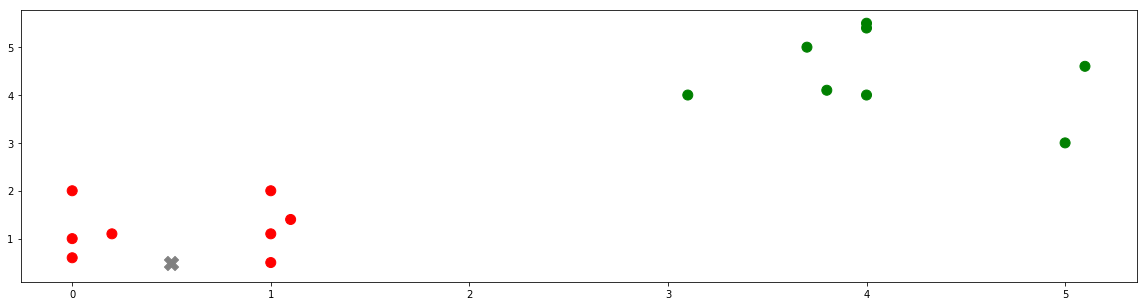

In [2]:
import sys
sys.path.append("D:/source/skratch/source")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

X = np.array([[0, 1], [1, 2], [0, 2], [1, 1.1], [1, 0.5], [0, 0.6], [0.2, 1.1], [1.1, 1.4],
              [5, 3], [4, 4], [3.7, 5], [3.1, 4], [4, 5.5], [5.1, 4.6], [3.8, 4.1], [4, 5.4]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

plt.figure(figsize=(20, 5))
plt.scatter(X[:, 0], X[:, 1],
            c=y,
            cmap=ListedColormap(['red', 'green']),
            s=100, marker='o')
plt.scatter([0.5], [0.5], c='gray', marker='X', s=200)
plt.show()

Now, just by looking at the plot, it seems quite obvious that the gray point is surrounded by red points, and therefore, it makes sense to classify it as red. This reasoning can be essentially summarized as "a point will have the class that most of its neighbours also have". Similarly, if all of these points were assigned some sort of value, it would make sense to assign the gray point, a value that is similar to the value of its neighbours.

This simple intuition is what K-Nearest Neighbours uses for both classification and regression!

## Implementation from "skratch"

Now, let's actually build a KNN classifier and a KNN regressor. As we've shown, both share much of the same logic, and therefore, most of the code will be identical.

First, we will define some generic `KNN` object. In the constructor, we pass two parameters:
- The number of neighbours
- Whether or not we want to use weighted distances

The `fit` function is extremely simple here. Indeed, all that is needed is to store the data that inside the object. Similarly, the `update` function only concatenates the existing data with the new one.

In [45]:
"""Implementation of KNN"""

from collections import Counter

import numpy as np

from utils.distances import euclidean, cdist


class KNN:

    def __init__(self, k=1, weighted=False):

        self.k = k
        self.weighted = weighted

    def fit(self, X, y):

        self.X_ = X
        self.y_ = y

        return self

    def update(self, X, y):

        self.X_ = np.concatenate((self.X_, X))
        self.y_ = np.concatenate((self.y_, y))

        return self

In order to predict, we need to do two things:

- Find the K-nearest neighbours by computing their distances to each of our example   
- Given these neighbours and their distances, vote to define the output

In [46]:
    def predict(self, X):

        predictions = []

        for x in X:

            neighbours, distances = self._get_neighbours(x)

            prediction = self._vote(neighbours, distances)

            predictions.append(prediction)

        return np.array(predictions)

Retrieving the neighbours can be done by simply calculating all pairwise distances between our example and the data stored inside the model. Once these distances are known, the K instances that have the shortest distance to the example are returned.

In this case, the distance is defined as the Euclidean distance between two instances.

In [47]:
    def _get_neighbours(self, x):

        distances = np.array([self._distance(x, x_) for x_ in self.X_])
        indices = np.argsort(distances)[:self.k]

        return self.y_[indices], distances[indices]

    def _distance(self, a, b):

        return euclidean(a, b)

We also need to compute the weights that we would like to assign to each neighbour. Typically, this is done by favouring neighbours that are closer by given them a weight equal to 1 divided by their distance.

>Here we also cover the situation where a neighbour might have a distance of 0. Obviously, we can't divide by zero, so we assign this neighbour a weight of 1 and all other neighbours a weight of zero. This is also how scikit-learn deals with this situation according to their source code.

In [48]:
    def _get_weights(self, distances):

        weights = np.ones_like(distances, dtype=float)

        if self.weighted:
            if any(distances == 0):
                weights[distances != 0] = 0
            else:
                weights /= distances

        return weights

Now, the last thing that we need to define is how to vote to define the output. This part is the only thing that the KNN classifier and regressor do differently, and therefore, we will reserve it to their respective classes.

>We added the function here to reinforce the fact that a voting scheme is needed. Don't worry about the error being thrown here.

In [49]:
    def _vote(self, targets, distances):
        raise NotImplementedError("KNN requires a _vote function")

In the classification case, given the neighbours and their weights, we define the class of our example by using a weighted majority voting. It works the same way as a regular majority voting except that instead of each voter having 1 vote each, their weight represents "how many" votes they get.

In [50]:
class KNN_Classifier(KNN):

    def _vote(self, classes, distances):

        weights = self._get_weights(distances)

        frequencies = {c: np.sum(weights[classes == c]) for c in list(set(classes))}

        return max(classes, key=frequencies.get)

In the regression case, we use a simple weighted average.

>https://en.wikipedia.org/wiki/Weighted_mean

In [51]:
class KNN_Regressor(KNN):

    def _vote(self, targets, distances):

        weights = self._get_weights(distances)

        return np.sum(weights * targets) / np.sum(weights)

And now, we could for instance use the `KNN_Classifier` to classify that gray point that we had mentioned at the beginning of the notebook.

from supervised.knn import KNN_Classifier#, KNN, KNN_Regressor

In [ ]:
from supervised.knn import KNN_Classifier#, KNN, KNN_Regressor

X = np.array([[0, 1], [1, 2], [0, 2], [1, 1.1], [1, 0.5], [0, 0.6], [0.2, 1.1], [1.1, 1.4],
              [5, 3], [4, 4], [3.7, 5], [3.1, 4], [4, 5.5], [5.1, 4.6], [3.8, 4.1], [4, 5.4]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

clf = KNN_Classifier(k=3)
clf.fit(X, y)
clf.predict([[0.5,0.5]])

As expected, the class is `0`, which corresponds to the red class.

## FAQ

### Why is it called a lazy learner?

A lazy learner is a model that only learns when it is asked to make a prediction. KNN is a lazy learner because as we've shown, everything happens in the `predict` method as opposed to the `fit` method.
>https://en.wikipedia.org/wiki/Lazy_learning

### What is the best value for K?

$K$ is a hyperparameter and picking the right one is highly dependent on the task at hand. Typically, only odd numbers are chosen to avoid ties, and because of Occam's razor, it is often assumed that smaller values of $K$ are preferable. Sometimes, a rule of thumb of chosing $K = \frac{\sqrt{n}}{2}$ is proposed if there are $n$ data points, but there is no strong theory behind it. 

### What distance measure should I use?

Again, picking an appropriate distance measure can make a huge difference with KNN. Since it is a lazy learner, and therefore doesn't require training time, it is often possible to plainly compare different distance measures and pick the best one.

### Why weight the neighbours?

Weighting the neighbours can turn out to be useful to increase the performance, but it is always wise to experiment with and without weighting to see what performs best. In our case, we gave a higher weights to the closest neighbours, but obviously, more complex weighting schemes can be experimented.

### Why is KNN a meta-learner?

KNN is a meta-learner in the sense that the voting scheme can be made as complex as you want. If you'd like to replace the majority voting scheme explained in this tutorial, by a deep neural network, it is entirely possible. It is considered a meta-learner because it learns "how to learn" by selecting the instances on which a decision has to then be made.

### Are there other ways to find the closest neighbours?

The K-nearest neighbours according to a certain distance measure will always be the same, but there exists many different algorithm to find them efficiently. A famous one involves storing the data in a KD-tree. In this tutorial, we used brute force, but in some cases, this might take too much time.
>https://en.wikipedia.org/wiki/Kd-tree

## Useful resources

Sklearn:
http://scikit-learn.org/stable/modules/neighbors.html

Machine Learning Mastery:
https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

ML from scratch:
https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/supervised_learning/k_nearest_neighbors.py

Videos:
https://www.youtube.com/watch?v=UqYde-LULfs (Thales Sehn Körting)
https://www.youtube.com/watch?v=4ObVzTuFivY (Mathematical Monk)